##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

## Preparation

In [13]:
# prepare environment

!pip install -q mediapipe
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

# !wget -q -O image.jpg https://cdn.pixabay.com/photo/2019/03/12/20/39/girl-4051811_960_720.jpg

import cv2
from google.colab.patches import cv2_imshow

# img = cv2.imread("image.jpg")
# cv2_imshow(img)



## Upload file

In [14]:
from google.colab import files
import os

def GetFileFromUser():

  uploaded = files.upload()

  # Check if any file was uploaded
  if uploaded:
    for filename in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=filename, length=len(uploaded[filename])))

      # Save the uploaded video to a file
      with open(filename, 'wb') as f:
        f.write(uploaded[filename])

      print(f"Saved video file as: {filename}")

      # Now you can proceed with processing the video using 'filename'
      # ... your video processing code here ...
      return filename
  else:
    print("No video file uploaded.")


filename = GetFileFromUser()

import os

def GetConvertedFileName(filename):
  base_dir, old_filename = os.path.split(filename)
  new_filename = os.path.splitext(old_filename)[0] + "_converted" + os.path.splitext(old_filename)[1]
  new_path = os.path.join(base_dir, new_filename)
  return new_path

converted_file_name = GetConvertedFileName(filename)

!ffmpeg -i "$filename" -vcodec libx264 "$converted_file_name" -hide_banner -loglevel error

print(f"converted file is at {converted_file_name}")


Saving y2meta.net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k.mp4 to y2meta.net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k.mp4
User uploaded file "y2meta.net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k.mp4" with length 1554359 bytes
Saved video file as: y2meta.net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k.mp4
converted file is at y2meta.net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k_converted.mp4


## Analyze video

In [16]:
from google.colab import files
import io
import cv2
import numpy as np
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from google.colab.patches import cv2_imshow
import mediapipe as mp
import time


# Visualization function (same as before)
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

# NormalizedLandmark to dict
def landmark_to_dict(landmark):
  return {
      'x': landmark.x,
      'y': landmark.y,
      'z': landmark.z,
      'visibility': landmark.visibility,
      'presence': landmark.presence,
  }

# MediaPipe setup (same as before)
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

def AnalyzeVideo(video_path):
  results = []
  # Video analysis with frame skipping for per-second analysis
  try:
      cap = cv2.VideoCapture(video_path)
      fps = cap.get(cv2.CAP_PROP_FPS)
      frame_skip = int(fps)  # Skip frames to process approximately every second
      frame_count = 0

      if not cap.isOpened():
          print("Error opening video file.")
      else:
          print("Analyzing the video file")
          while(cap.isOpened()):
              ret, frame = cap.read()
              if ret == True:
                  if frame_count % frame_skip == 0:  # Process every 'frame_skip' frames
                      image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                      detection_result = detector.detect(image)
                      results.append(
                          {
                              frame_number: frame_count,
                              results: [[landmark_to_dict(l) for l in person_landmarks] for person_landmarks in detection_result.pose_landmarks]
                          })
                      print(detection_result)

                      # annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
                      # cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))  # Display the frame
                      # Add any further analysis or processing here using 'detection_result'
                      time.sleep(0.1) # to slow down video

                  frame_count += 1
                  if cv2.waitKey(1) & 0xFF == ord('q'):
                      break
              else:
                  break

      cap.release()
      cv2.destroyAllWindows()
  except Exception as e:
      print(f"An error occurred: {e}")
  return results

video_results = AnalyzeVideo(converted_file_name)

import json
json_res = json.dumps(video_results)

def GetResultsFileName(filename):
  base_dir, old_filename = os.path.split(filename)
  new_filename = os.path.splitext(old_filename)[0] + "_results.json"
  new_path = os.path.join(base_dir, new_filename)
  return new_path

results_path = GetResultsFileName(converted_file_name)
with open(results_path, 'w') as f:
  f.write(json_res)


Analyzing the video file
PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.52837735414505, y=0.34956657886505127, z=-0.13704726099967957, visibility=0.9999963045120239, presence=0.999998927116394), NormalizedLandmark(x=0.5379690527915955, y=0.3388161063194275, z=-0.11681853979825974, visibility=0.9999895095825195, presence=0.999997615814209), NormalizedLandmark(x=0.5447698831558228, y=0.33858567476272583, z=-0.11710856854915619, visibility=0.9999872446060181, presence=0.9999977350234985), NormalizedLandmark(x=0.5516788959503174, y=0.3382953107357025, z=-0.11696865409612656, visibility=0.9999914169311523, presence=0.9999972581863403), NormalizedLandmark(x=0.5186201930046082, y=0.3397630453109741, z=-0.1050303652882576, visibility=0.9999927282333374, presence=0.9999964237213135), NormalizedLandmark(x=0.51291424036026, y=0.3403419256210327, z=-0.10548699647188187, visibility=0.9999905824661255, presence=0.9999963045120239), NormalizedLandmark(x=0.5073979496955872, y=0.340828061

## Visualize Result

In [17]:
frame_number = int(input("Choose frame to visualize: "))
print(f"You entered: {frame_number}")

Choose frame to visualize: 5
You entered: 5


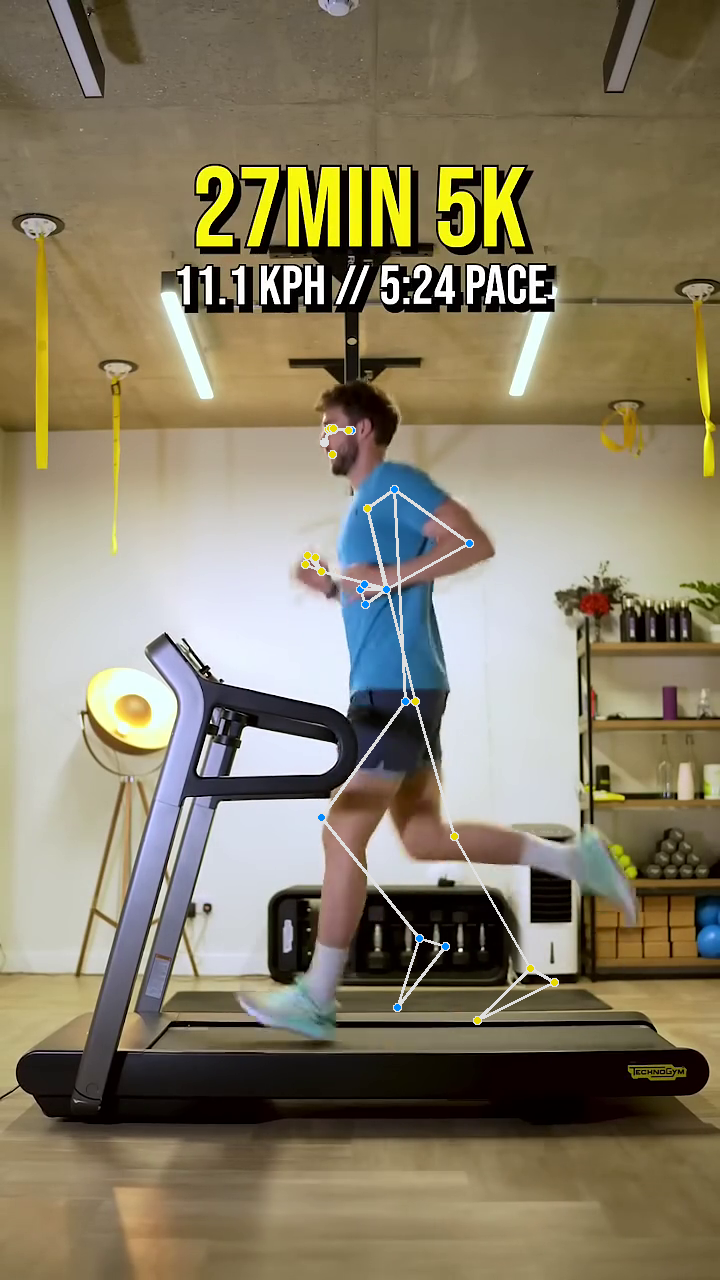

In [22]:


video_file = converted_file_name
results_file = results_path
with open(results_file, 'r') as f:
    video_results = json.load(f)

# extract frame number X from video
def GetFrameFromVideo(video_file, frame_number):
  cap = cv2.VideoCapture(video_file)
  cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
  ret, frame = cap.read()
  cap.release()
  return frame

frame = GetFrameFromVideo(video_file, frame_number*30)
# cv2_imshow(frame)

image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Visualization function (same as before)
def draw_landmarks_on_image(rgb_image, pose_landmarks_list):
    annotated_image = np.copy(rgb_image)

    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

image_results = video_results[frame_number]
# convert dict to back to NormalizedLandmark
image_results = [
    [landmark_pb2.NormalizedLandmark(**landmark) for landmark in person_landmarks]
    for person_landmarks in image_results
]
annotated_image = draw_landmarks_on_image(image.numpy_view(), image_results)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))  # Display the frame



In [ ]:
!pip install -q mediapipe

Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker#models) for more information about this model bundle.

In [ ]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

## Visualization utilities

In [ ]:
#@markdown To better demonstrate the Pose Landmarker API, we have created a set of visualization tools that will be used in this colab. These will draw the landmarks on a detect person, as well as the expected connections between those markers.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

## Download test image

To demonstrate the Pose Landmarker API, you can download a sample image using the follow code. The image is from [Pixabay](https://pixabay.com/photos/girl-woman-fitness-beautiful-smile-4051811/).

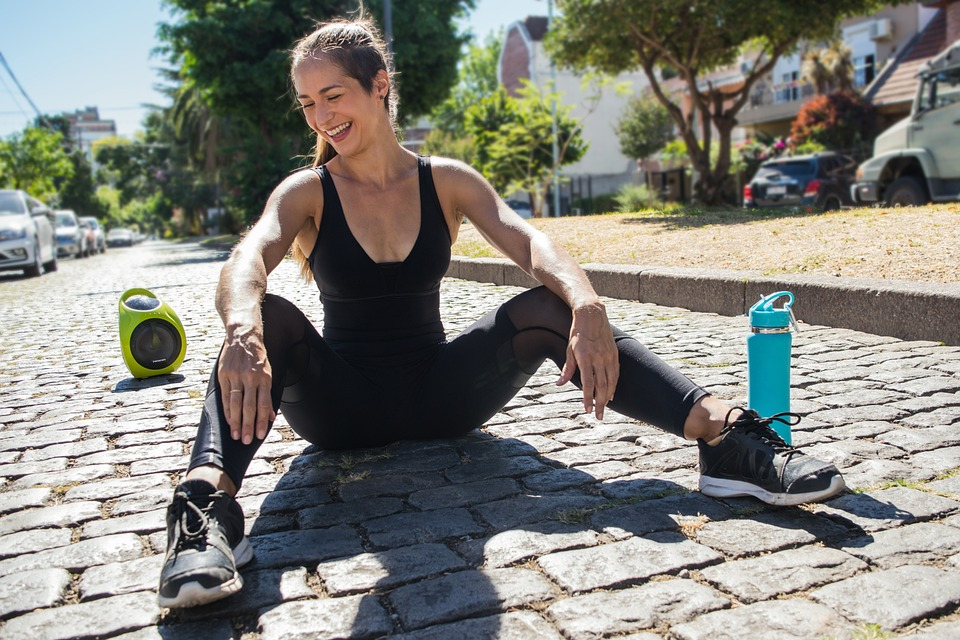

In [ ]:
!wget -q -O image.jpg https://cdn.pixabay.com/photo/2019/03/12/20/39/girl-4051811_960_720.jpg

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("image.jpg")
cv2_imshow(img)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

## Running inference and visualizing the results

The final step is to run pose landmark detection on your selected image. This involves creating your PoseLandmarker object, loading your image, running detection, and finally, the optional step of displaying the image with visualizations.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker/python) to learn more about configuration options that this solution supports.


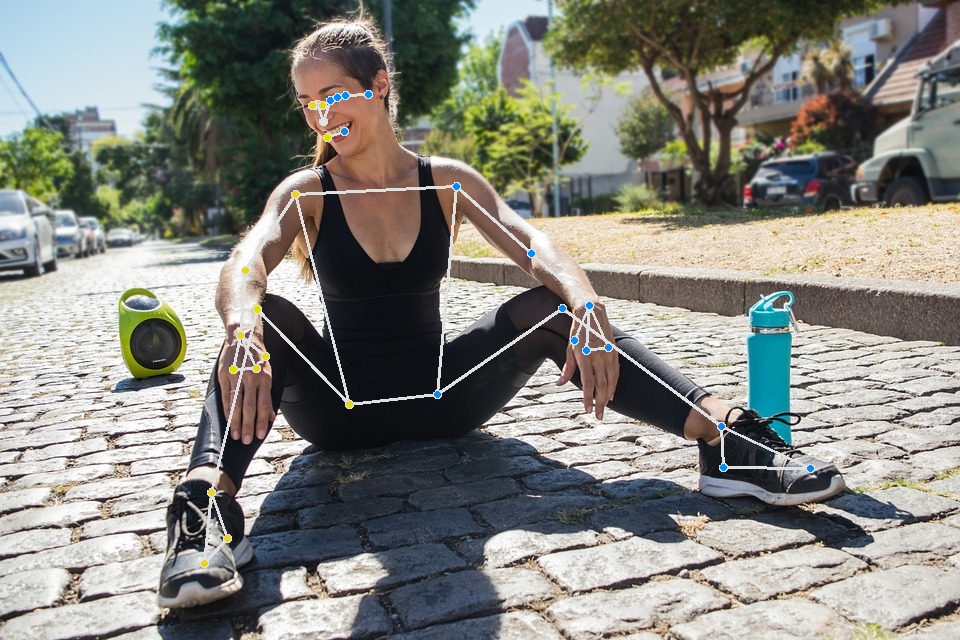

In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

Visualize the pose segmentation mask.

In [ ]:
!ffmpeg -i treadmile.mp4 -vcodec libx264 treadmile_converted.mp4


In [ ]:
from google.colab import files
import io
import cv2
import numpy as np
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from google.colab.patches import cv2_imshow
import mediapipe as mp
import time


# Visualization function (same as before)
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image


# MediaPipe setup (same as before)
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# Video analysis with frame skipping for per-second analysis
try:
    cap = cv2.VideoCapture('treadmile_converted.mp4')
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip = int(fps)  # Skip frames to process approximately every second
    frame_count = 0

    if not cap.isOpened():
        print("Error opening video file.")
    else:
        print("Analyzing the video file")
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret == True:
                if frame_count % frame_skip == 0:  # Process every 'frame_skip' frames
                    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    detection_result = detector.detect(image)
                    print(detection_result)
                    annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
                    cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))  # Display the frame
                    # Add any further analysis or processing here using 'detection_result'
                    time.sleep(0.1) # to slow down video

                frame_count += 1
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break

    cap.release()
    cv2.destroyAllWindows()
except Exception as e:
    print(f"An error occurred: {e}")